In [1]:
import geopandas as gp
import movingpandas as mpd
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
from shapely.geometry import Point

In [2]:
gdf = gp.read_file('../data/freemove/raw_full.geojson', crs='EPSG:4326')

In [3]:
# create geojson of points
rows = []
for i, row in tqdm(gdf.iterrows(), total=len(gdf), miniters=10):
    person_id = row.PERSON_ID
    trip_id = row.TRIP_ID
    leg_id = row.LEG_ID
    leg_start = datetime.strptime(row.LEG_START, '%Y-%m-%dT%H:%M:%S')
    leg_end = datetime.strptime(row.LEG_END, '%Y-%m-%dT%H:%M:%S')
    trip_purpose_ids = row.TRIP_PURPOSE_IDS
    traffic_mode = row.TRAFFIC_MODE
    leg_len_in_mtrs = row.LEG_LEN_IN_MTRS
    leg_duration_in_secs = row.LEG_DURATION_IN_SECS

    # interpolate time of points of a leg since we only have start and end time
    total_points_of_leg = len(row.geometry.coords)
    interpolattion_increment = leg_duration_in_secs / total_points_of_leg

    for point_i, point in enumerate(row.geometry.coords):
        new_row = {"PERSON_ID": person_id, 
                   "TRIP_ID": trip_id, 
                   "LEG_ID": leg_id, 
                   "LEG_START": leg_start, 
                   "LEG_END": leg_end,
                   "TIME": leg_start + timedelta(seconds=round(interpolattion_increment * point_i, ndigits=0)),
                   "TRIP_PURPOSE_IDS": trip_purpose_ids, 
                   "TRAFFIC_MODE": traffic_mode, 
                   "LEG_LEN_IN_MTRS": leg_len_in_mtrs, 
                   "LEG_DURATION_IN_SECS": leg_duration_in_secs, 
                   "LAT": Point(point).y,
                   "LON": Point(point).x}
        rows.append(new_row)


freemove_raw_point_gdf = pd.DataFrame(rows)[["PERSON_ID", "TRIP_ID", "TIME", "LAT", "LON"]]
freemove_raw_point_gdf

100%|██████████| 4958/4958 [00:46<00:00, 107.44it/s]


,PERSON_ID,TRIP_ID,TIME,LAT,LON
0,16348,985222,2022-10-31 09:15:57,52.454451,13.504967
1,16348,985222,2022-10-31 09:15:58,52.454463,13.504983
2,16348,985222,2022-10-31 09:15:59,52.454454,13.505009
3,16348,985222,2022-10-31 09:16:00,52.454422,13.505042
4,16348,985222,2022-10-31 09:16:01,52.454391,13.505098
...,...,...,...,...,...
1637556,17273,1012443,2022-11-15 10:00:46,52.501937,13.355693
1637557,17273,1012443,2022-11-15 10:00:47,52.501903,13.355708
1637558,17273,1012443,2022-11-15 10:00:48,52.501874,13.355723
1637559,17273,1012443,2022-11-15 10:00:49,52.501847,13.355738


<AxesSubplot: >

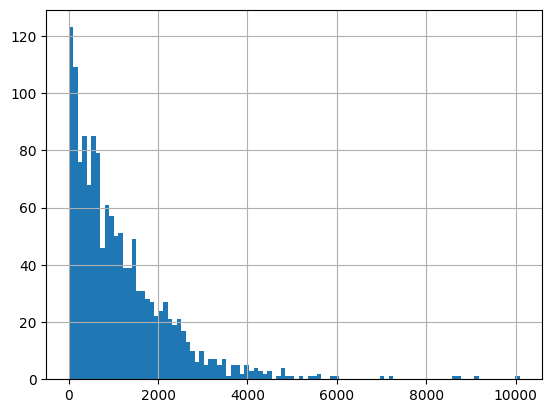

In [4]:
# plot the distribution of the number of points per trajectory
freemove_raw_point_gdf.groupby('TRIP_ID').size().hist(bins=100)


In [5]:
freemove_point_collection = mpd.TrajectoryCollection(freemove_raw_point_gdf, traj_id_col='TRIP_ID', obj_id_col ='PERSON_ID', t='TIME', x='LON', y='LAT', crs='epsg:4326')

In [7]:
detector = mpd.TrajectoryStopDetector(freemove_point_collection)

In [ ]:
start_locations = freemove_point_collection.get_start_locations().reset_index(names=['TIME'])[['TRIP_ID', 'PERSON_ID', 'TIME', 'geometry']]
end_locations = freemove_point_collection.get_end_locations().reset_index(names=['TIME'])[['TRIP_ID', 'PERSON_ID', 'TIME', 'geometry']]

In [9]:
stop_points = detector.get_stop_points(min_duration=timedelta(seconds=60), max_diameter=200).reset_index()

In [6]:
stop_points = detector.get_stop_points(min_duration=timedelta(seconds=60), max_diameter=200).reset_index()
stop_points['time'] = (stop_points['end_time'] - stop_points['start_time']) + stop_points['start_time']
stop_points = pd.merge(stop_points[['traj_id', 'time', 'geometry']], start_locations[['TRIP_ID', 'PERSON_ID', 'lon', 'lat']], on='traj_id', how='left')

In [7]:
points = pd.concat([start_locations, stop_points, end_locations]).sort_values(['traj_id', 'time']).reset_index(drop=True)
points.head(10)

,traj_id,user,time,lon,lat,geometry
0,1000064,16944,2022-11-05 23:25:52,13.422014,52.535668,POINT (4553108.640 3275063.614)
1,1000064,16944,2022-11-05 23:30:01,13.422014,52.535668,POINT (4553127.606 3275088.327)
2,1000064,16944,2022-11-05 23:44:45,13.386470,52.549784,POINT (4550624.482 3276521.248)
3,1000070,16361,2022-11-05 23:47:50,13.397375,52.529760,POINT (4551468.711 3274328.900)
4,1000070,16361,2022-11-06 00:08:22,13.389913,52.548480,POINT (4550865.310 3276386.503)
5,1000071,16361,2022-11-06 00:18:53,13.390040,52.548529,POINT (4550862.623 3276388.423)
6,1000071,16361,2022-11-06 00:25:35,13.300270,52.530377,POINT (4544805.194 3274065.725)
7,1000173,16972,2022-11-06 00:38:31,13.471125,52.502657,POINT (4556613.226 3271552.583)
8,1000173,16972,2022-11-06 01:08:27,13.471125,52.502657,POINT (4576180.407 3275141.285)
9,1000173,16972,2022-11-06 01:11:47,13.753683,52.519917,POINT (4575673.592 3274424.376)


In [8]:
# normalize a list of integers and round to 2 decimals
def normalize_list(l):
    return [round(x / max(l), 2) for x in l]    

points['geographical_context'] = [normalize_list([np.random.randint(0, 500) for i in range(20)]) for j in range(len(points))]

In [9]:
import targomo_api
from tqdm import tqdm
tqdm.pandas()

points['geographical_context'] = points.progress_apply(lambda x: targomo_api.get_geographical_context_vector(x.lat, x.lon), axis=1)

# save to pickle
points.to_pickle('../data/freemove/freemove_point_geographical_context.pickle')

100%|██████████| 3760/3760 [3:15:13<00:00,  3.12s/it]  


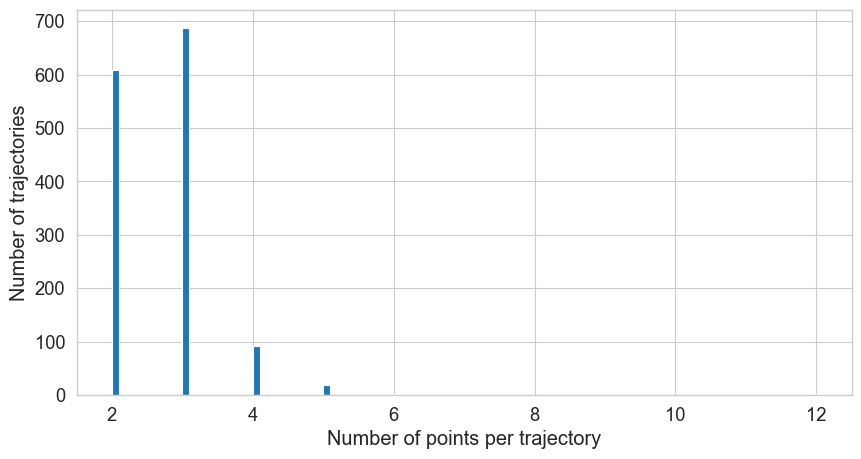

In [10]:
# plot distribution of number of points per trajectory
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(10, 5))
plt.hist(points.groupby('traj_id').count()['user'], bins=100)
plt.xlabel('Number of points per trajectory')
plt.ylabel('Number of trajectories')
plt.show()

In [11]:
max_points = points.groupby('traj_id').count()['user'].max()
geographical_context_dim = len(points['geographical_context'].iloc[0])


X = np.empty(shape=[points.traj_id.nunique(), max_points, geographical_context_dim])
Y = np.empty(shape=[points.traj_id.nunique(),])

In [12]:
# convert points into numpy array for each trajectory
for index, traj in enumerate(points.groupby('traj_id')):    
    # get the trajectory id
    traj_id = traj[0]

    # get the user id
    user_id = traj[1]['user'].iloc[0]

    Y[index] = user_id

    for idx, point in traj[1].reset_index(drop=True).iterrows():
        X[index, idx, :] = point['geographical_context']

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LSTM, RepeatVector

timesteps = 12
input_dim = 10
latent_dim = 60

inputs = keras.Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = keras.Model(inputs, decoded)
encoder = keras.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer='adam', loss='mae')

sequence_autoencoder.fit(X, X,
                epochs=1000,
                batch_size=256,
                shuffle=True)

Epoch 1/1000
6/6 [==============================] - 3s 17ms/step - loss: 0.0737
Epoch 2/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0728
Epoch 3/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0723
Epoch 4/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0721
Epoch 5/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.0719
Epoch 6/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.0718
Epoch 7/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.0717
Epoch 8/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.0717
Epoch 9/1000
6/6 [==============================] - 0s 16ms/step - loss: 0.0717
Epoch 10/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0717
Epoch 11/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0717
Epoch 12/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0717
Epoch 13/1000
6/6 [==================

KeyboardInterrupt: 